In [33]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
plt.rc('text', usetex=False)
sns.set_style('ticks', {'font_scale': 1.1})

import random
import numpy as np

import gcsfs

from functools import partial 

import xarray as xr
from dask.distributed import Client

%matplotlib inline

PNW_LAT = slice(1.52, 63.4)
PNW_LON =slice(-170, -103)

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:38591 Dashboard: /user/acannistra/proxy/8787/status,Cluster Workers: 4 Cores: 4 Memory: 25.77 GB


# Phytoplankton Thermal Performance Curves + SST 
*from Thomas et al., 2016 https://onlinelibrary.wiley.com/doi/full/10.1111/geb.12387 and others via Lauren ceilley (https://github.com/HuckleyLab/ThermalStress/blob/master/ToptCTmax_assembledata.R)*

## Prepare the Data


In [2]:
plankton = pd.read_csv("../../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/traits_derived_2016_01_29.csv", engine='python')

In [3]:
len(plankton)

474

In [4]:
len(set(list(zip(plankton.genus, plankton.species))))

253

*There is more than 1 example per species*. We'll isolate only those curves which contain "good" fits. R code:

```
plank= subset(plank, plank$minqual=="good" & plank$maxqual=="good" & plank$curvequal=="good" )
```

In [5]:
plankton = plankton[(plankton.minqual == "good") &
                    (plankton.maxqual == "good") &
                    (plankton.curvequal == "good")]

And also only the marine species:

In [6]:
plankton = plankton[plankton.habitat == 'marine']

In [7]:
print(len(plankton))
print(len(set(list(zip(plankton.genus, plankton.species)))))

96
62


In [60]:
genus = "Skeletonema"
plankton = plankton[plankton.genus == genus]

In [61]:
plankton

,isolate.code,source,isolation.latitude,isolation.longitude,habitat,name,speciesname,former.name.1,former.name.2,strain,...,minqual,maxqual,curvequal,abs.curveskew,rel.curveskew,used.for.optimum.analysis,used.for.tmax.analysis,used.for.tmin.analysis,used.for.niche.width.analysis,used.for.max.growth.rate.analysis
38,49,"Atlantic, off South America",5.00,-52.00,marine,Skeletonema tropicum clone S. trop.,Skeletonema tropicum,NaN,NaN,NaN,...,good,good,good,-192.541584,-0.013314,1.0,1.0,1.0,1.0,1.0
44,55,Suriname,6.00,-54.00,marine,Skeletonema tropicum clone fall,Skeletonema tropicum,NaN,NaN,NaN,...,good,good,good,-178.676071,-0.010174,1.0,1.0,1.0,1.0,1.0
64,81,"off Xiamen, China",24.49,118.11,marine,Skeletonema costatum,Skeletonema costatum,NaN,NaN,NaN,...,good,good,good,-359.369687,-0.020888,1.0,1.0,1.0,1.0,1.0
113,146,Tokyo Bay,35.50,140.00,marine,Skeletonema costatum,Skeletonema costatum,NaN,NaN,NaN,...,good,good,good,-498.216597,-0.014344,1.0,1.0,1.0,1.0,1.0
178,256,"Friday Harbour, WA, USA",48.54,-123.01,marine,Skeletonema costatum clone FHS 3,Skeletonema costatum,NaN,NaN,NaN,...,good,good,good,-309.835196,-0.014434,1.0,1.0,1.0,1.0,1.0
327,462,"Dokai Bay, Japan",33.93,130.83,marine,Skeletonema tropicum strain FDK199,Skeletonema tropicum,NaN,NaN,FDK199,...,good,good,good,-133.889294,-0.008170,1.0,1.0,1.0,1.0,1.0
328,463,"Dokai Bay, Japan",33.93,130.83,marine,Skeletonema tropicum strain FDK202,Skeletonema tropicum,NaN,NaN,FDK202,...,good,good,good,-270.964112,-0.015764,1.0,1.0,1.0,1.0,1.0
329,464,"Dokai Bay, Japan",33.93,130.83,marine,Skeletonema tropicum strain FDK204,Skeletonema tropicum,NaN,NaN,FDK204,...,good,good,good,-240.352925,-0.014546,1.0,1.0,1.0,1.0,1.0
330,465,"Dokai Bay, Japan",33.93,130.83,marine,Skeletonema tropicum strain FDK205,Skeletonema tropicum,NaN,NaN,FDK205,...,good,good,good,-336.669540,-0.018534,1.0,1.0,1.0,1.0,1.0
331,466,"Dokai Bay, Japan",33.93,130.83,marine,Skeletonema tropicum strain FDK207,Skeletonema tropicum,NaN,NaN,FDK207,...,good,good,good,-239.187904,-0.015029,1.0,1.0,1.0,1.0,1.0


## Reassemble Thermal Performance Curvesgenus

In [62]:
def tpc(T, a, b, z, w):
    '''
    https://science.sciencemag.org/content/sci/suppl/2012/10/25/science.1224836.DC1/Thomas.SM.pdf
    '''
    return a * np.exp(b*T) * (1 - ((T - z)/(w / 2))**2)

### Test on random plankton isolate

In [63]:
sample = plankton.sample(1).iloc[0]

In [64]:
sample

isolate.code                                                      472
source                                               Dokai Bay, Japan
isolation.latitude                                              33.93
isolation.longitude                                            130.83
habitat                                                        marine
name                                 Skeletonema ardens strain FDK004
speciesname                                        Skeletonema ardens
former.name.1                                                     NaN
former.name.2                                                     NaN
strain                                                         FDK004
clone                                                             NaN
species                                                        ardens
genus                                                     Skeletonema
family                                                Skeletonemaceae
order               

In [65]:
tpc(30, sample['mu.alist'], sample['mu.blist'], sample['mu.c.opt.list'], sample['mu.wlist'])

1.3389681720686932

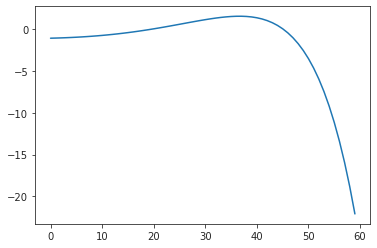

In [66]:
plt.plot([tpc(i, sample['mu.alist'], sample['mu.blist'], sample['mu.c.opt.list'], sample['mu.wlist']) for i in np.arange(-10, 50)])

In [67]:
def plot_tpc(sample, ax=None):
    T = np.arange(sample['mu.c.opt.list'] - (sample['mu.wlist'] / 2), sample['mu.c.opt.list'] + (sample['mu.wlist'] / 2), 0.1)
    perf = tpc(T, sample['mu.alist'], sample['mu.blist'], sample['mu.c.opt.list'], sample['mu.wlist'])
    try:
        plotTitle = "{} {} [{}]".format(sample.genus, sample.species, sample['isolate.code'])
    except AttributeError as e: 
        plotTitle = ""
    if ax:
        ax.plot(T, perf)
        ax.set_title(plotTitle)
        ax.set_xlabel("T")
        sns.despine(ax=ax)
    else:
        plt.plot(T, perf)
        plt.title(plotTitle)
        plt.xlabel("$T$ [${^\circ}{C}$]")
        sns.despine()

In [169]:
sample= plankton.loc[178]

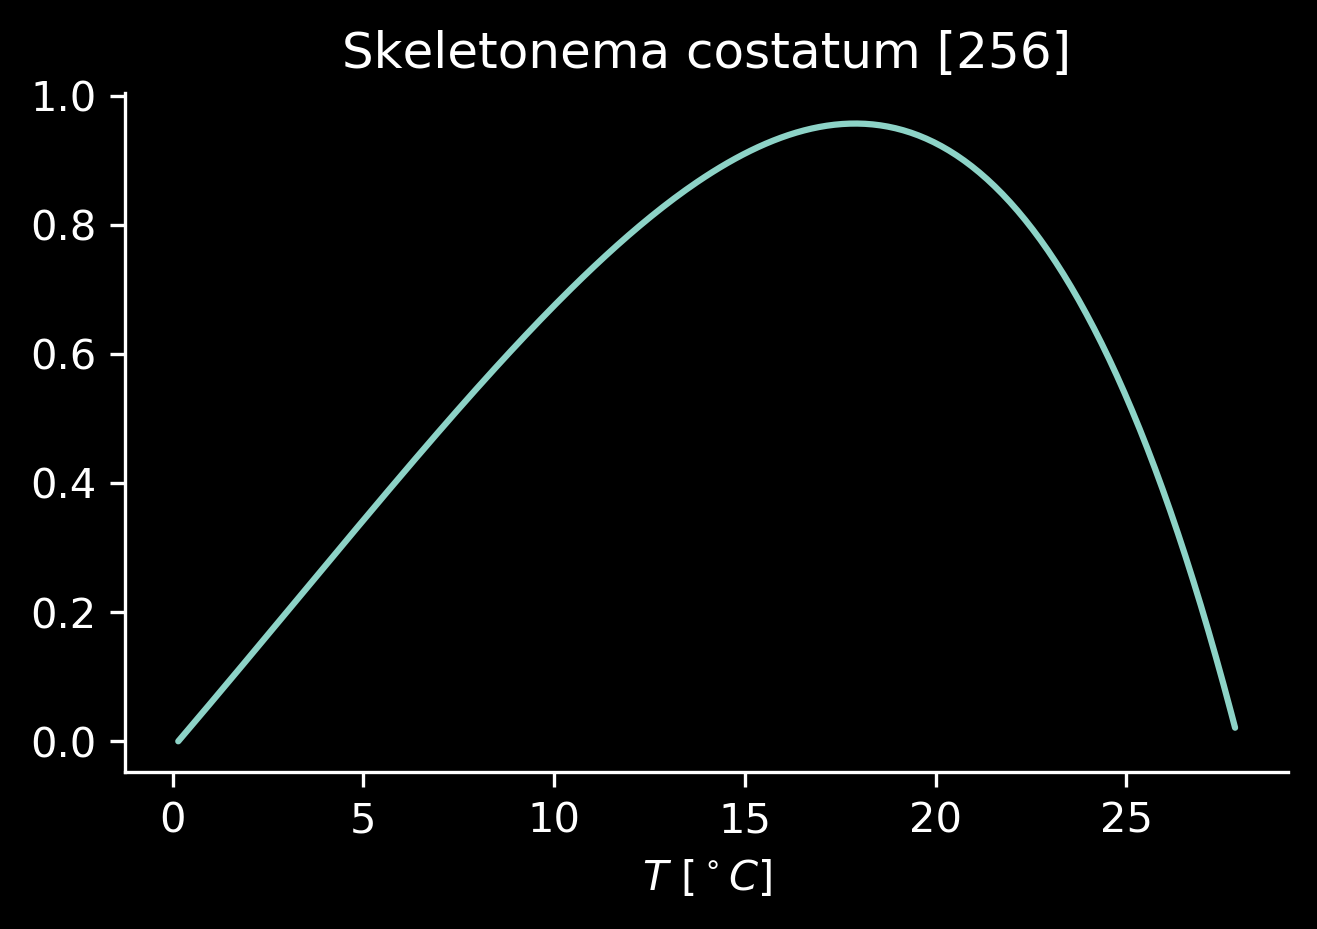

In [170]:
fig = plt.figure(figsize=(5,3), dpi=300)
plot_tpc(sample)

## Compute Performance Detriment
We're calling it like this: $$P_{det} = P(T_{opt}) - P(T)$$ where $P(T)$ is the value of the thermal performance curve at temperature $T$. 

In [175]:
sample = plankton.loc[178]


In [176]:
def perf_det(T, T_opt, tpc, axis=1):
    
    return tpc(T_opt) - tpc(T)

In [177]:
def plot_det(s, ax, t=None):
    this_tpc = partial(tpc, a=s['mu.alist'], b=s['mu.blist'], z=s['mu.c.opt.list'], w=s['mu.wlist'])
    T = np.arange(s['mu.c.opt.list'] - (s['mu.wlist'] / 2), s['mu.c.opt.list'] + (s['mu.wlist'] / 2), 0.1)
    
    try:
        plotTitle = "{} {} [{}]".format(sample.genus, sample.species, sample['isolate.code'])
    except AttributeError as e: 
        plotTitle = ""
    
    plt.title(plotTitle)
    
    perf = this_tpc(T)
    
    max_perf = this_tpc(s['mu.g.opt.list'])
    plt.scatter(s['mu.g.opt.list'], max_perf, color='red', zorder=5, label='$T_{opt} = ' + '{:.2f}$'.format(s['mu.g.opt.list']))
    
    if not t:
        randomT = np.random.choice(T, size=1)[0]
    else: 
        randomT = t
    perf_T = this_tpc(randomT)
    det_T = perf_det(randomT, s['mu.g.opt.list'], this_tpc)

    plt.plot(T, perf, label='Performance Curve')
    plt.vlines(randomT,0, perf_T, linewidth=2.5, color='green', label='Performance at $T = {:.2f}$'.format(randomT))
    plt.vlines(randomT,max_perf, max_perf - det_T, linewidth=2.5, color='red', label='Performance Detriment')
    plt.axhline(max_perf, linestyle='--', color='orange', label="Maximum Performance")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.ylabel("Growth Rate")
    plt.xlabel("Temperature [C]")

    sns.despine()
    plt.tight_layout()
    plt.savefig("{}_{}_{}.png".format(sample.genus, sample.species, sample['isolate.code']))

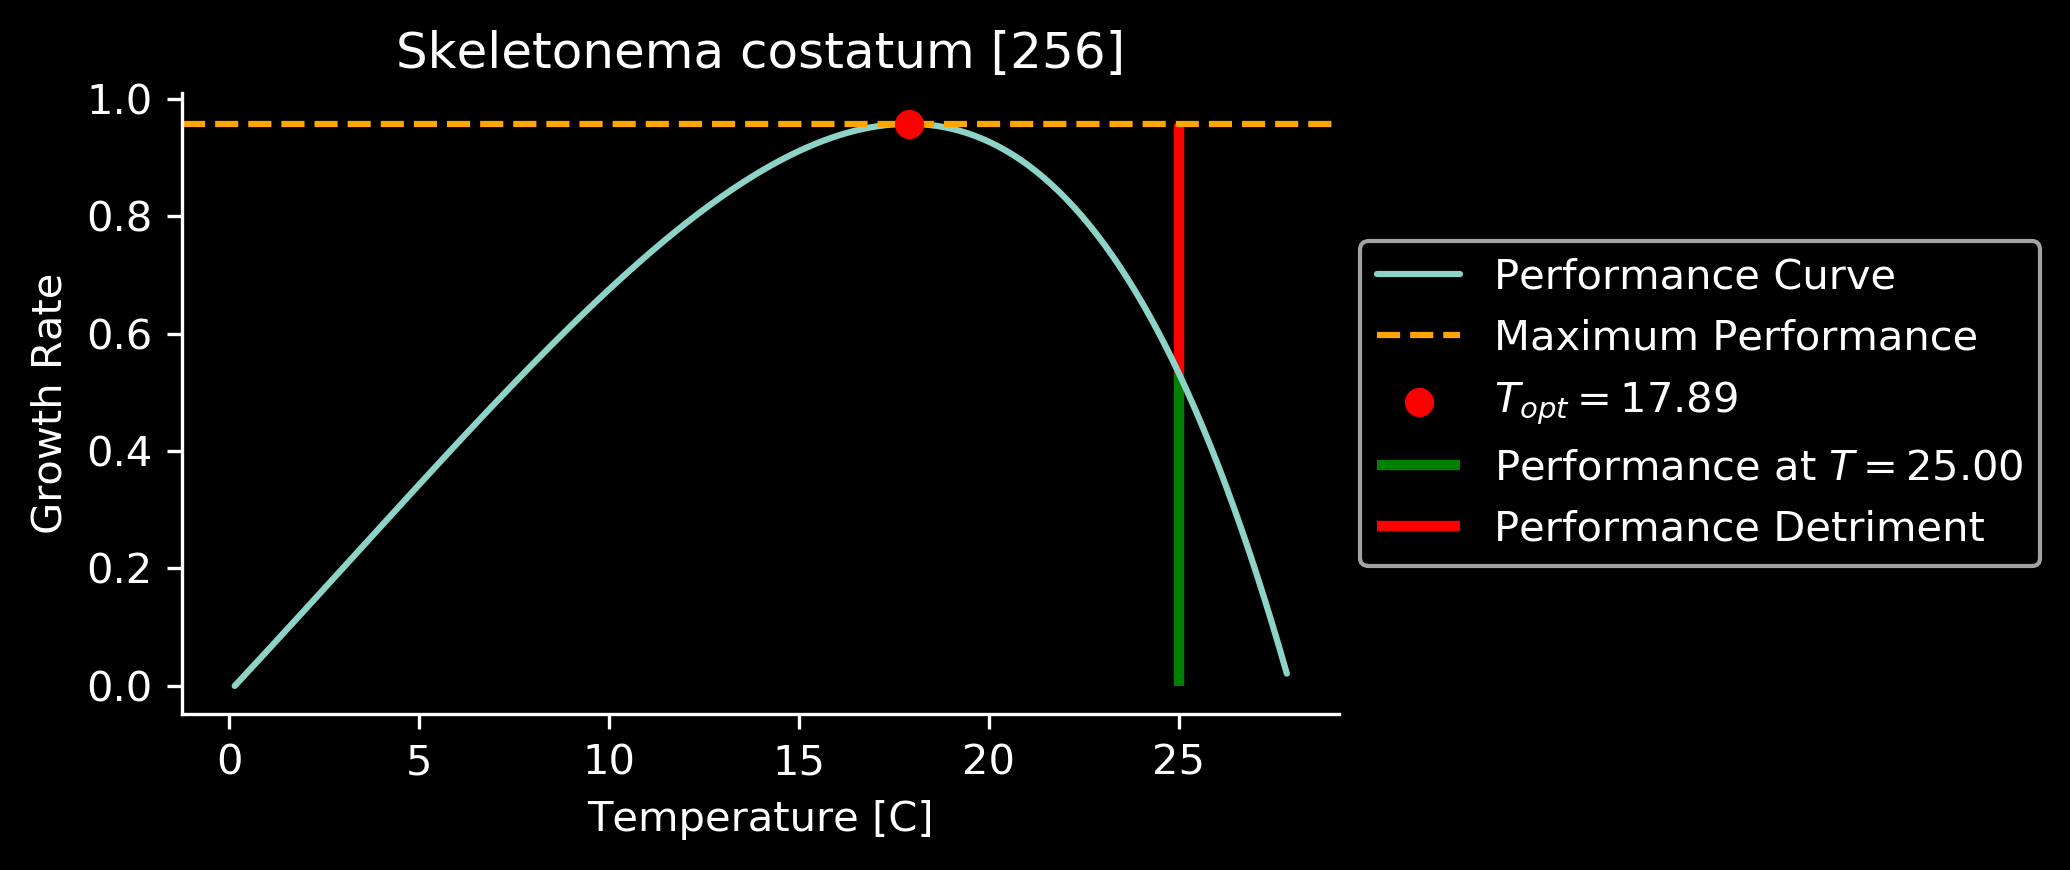

In [181]:
plt.style.use("dark_background")
fig = plt.figure(figsize=(7, 3), dpi=300)
plot_det(sample, ax=None, t= 25.)


In [182]:
sample['mu.g.opt.list']

17.89035061

In [20]:
s = sample
this_det = partial(perf_det, T_opt = sample['mu.g.opt.list'], tpc = partial(tpc, a=s['mu.alist'], b=s['mu.blist'], z=s['mu.c.opt.list'], w=s['mu.wlist']))

## Work in SST

In [21]:
gcp_project_id = '170771369993'
fs = gcsfs.GCSFileSystem(project=gcp_project_id, token="/home/jovyan/gc-pangeo.json")

In [22]:
oisst = xr.open_zarr(fs.get_mapper('oisst/oisst.zarr'))
# reproject oisst into actual longitudes
oisst = oisst.assign_coords(lon=(((oisst.lon + 180) % 360) - 180)).sortby('lon')

In [23]:
oisst

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 13636)
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875
  * time     (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2018-12-31
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(100, 50, 280), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    history:        Thu Aug 24 13:34:17 2017: ncatted -O -a References,global...
    institution:    NOAA/NCDC
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    title:          NOAA High-resolution Blended Analysis: Daily Values using...

In [24]:
ans = oisst.sel(time=slice('1995-01-01', '1995-12-31'), lat=PNW_LAT, lon=PNW_LON).sst.reduce(this_det, dim='time').compute()

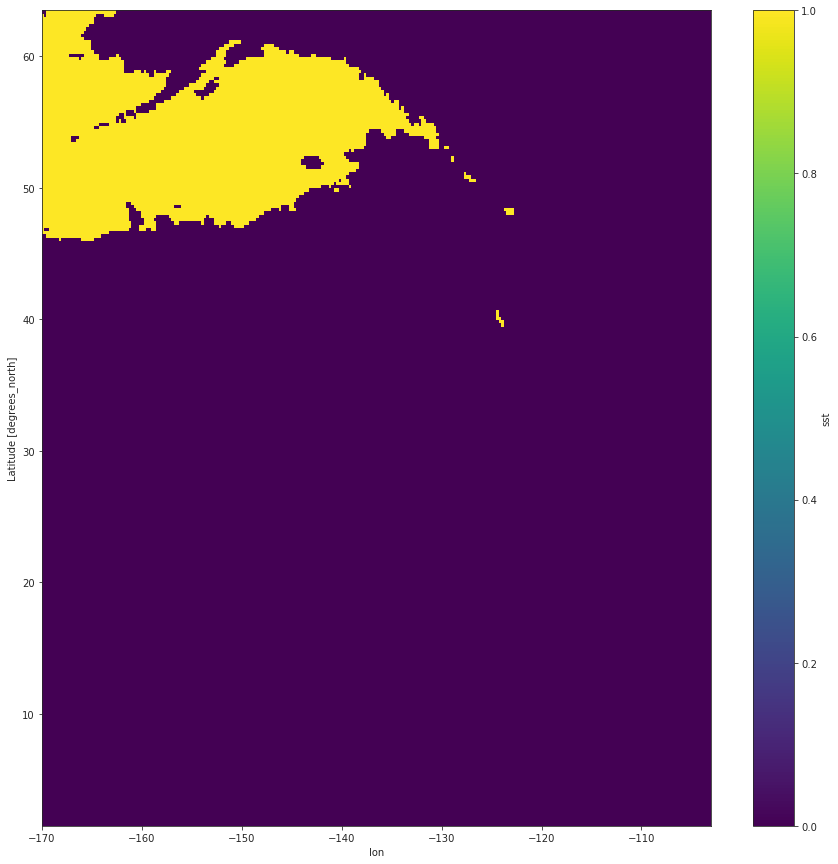

In [51]:
summed = (ans.min(dim='time') > 1).plot(figsize=(15,15))

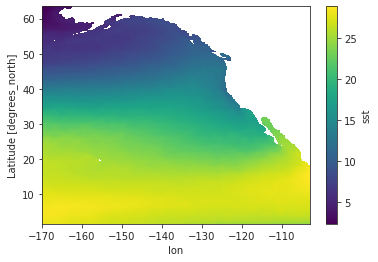

In [53]:
 oisst.sel(time=slice('1995-01-01', '1995-12-31'), lat=PNW_LAT, lon=PNW_LON).sst.mean(dim='time').plot()

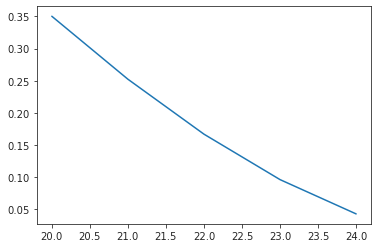

In [56]:
det = this_det(np.arange(20, 25))
plt.plot(np.arange(20, 25), det)